# 1. Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# import dataset
df = pd.read_excel("Data_Train.xlsx")
display(df)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


## 1.1 Drop nulls and duplicates

In [2]:
# drop null value
df.dropna(inplace=True)

# drop duplicates
df.drop_duplicates(keep='first', inplace=True)

## 1.2 Convert time variables

In [3]:
# convert Dep_Time and Arrival_Time into hour and minute
# Dep_Time
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
df["Dep_minute"] = pd.to_datetime(df["Dep_Time"]).dt.minute
df = df.drop(columns="Dep_Time")

# Arrival_Time
df["Arr_hour"] = pd.to_datetime(df["Arrival_Time"]).dt.hour
df["Arr_minute"] = pd.to_datetime(df["Arrival_Time"]).dt.minute
df = df.drop(columns="Arrival_Time")

# convert Date_of_Journey into timestamp
df["Date_of_Journey_Year"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.year
# ps. I don't think "year" is mandatory
df["Date_of_Journey_Month"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.month
df["Date_of_Journey_Day"] = pd.to_datetime(
    df["Date_of_Journey"], format="%d/%m/%Y").dt.day
df = df.drop(columns="Date_of_Journey")


# convert Duration into minute
df['Duration'] = df['Duration']\
    .str.replace("h", '*60')\
    .str.replace(' ', '+')\
    .str.replace('m', '*1')\
    .apply(eval)

## 1.3 Drop ... columns
- ["Additional_Info"]
    - Most of the values are "No Info"
- ["Route"]
    - hard to process
    - can use Total_Stops instead

In [4]:
# drop Additional_Info 
df.drop(['Additional_Info'], axis=1, inplace=True)

In [5]:
# drop Route
df.drop(['Route'], axis=1, inplace=True)

## 1.4 Encode categorical attributes

In [6]:
# Select categorical data
df_categorical = df[['Airline', 'Source', 'Destination']]
df.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True)

# Encode
df_categorical = pd.get_dummies(df_categorical, drop_first=True)
df['Total_Stops'] = df['Total_Stops'].map({"non-stop":0, "1 stop": 1, "2 stops": 2, "3 stops":3, "4 stops": 4})

# Concat categorical and numerical data
preprocessed = pd.concat([df, df_categorical], axis=1)

## 1.5 Feature Engineering

In [7]:
import datetime

def CheckWeekend(year, month, day):
    convertDate = datetime.date(year, month, day)
    convertDateResult = convertDate.weekday()
    if convertDateResult <= 4:
        return False
    return True

In [8]:
# check if date is weekday or weekend
preprocessed["IsWeekend"] = preprocessed.apply(lambda x: 1 if CheckWeekend(x["Date_of_Journey_Year"], x["Date_of_Journey_Month"], x["Date_of_Journey_Day"]) else 0, axis=1)

In [9]:
print(preprocessed.columns)
display(preprocessed)

Index(['Duration', 'Total_Stops', 'Price', 'Dep_hour', 'Dep_minute',
       'Arr_hour', 'Arr_minute', 'Date_of_Journey_Year',
       'Date_of_Journey_Month', 'Date_of_Journey_Day', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi', 'IsWeekend'],
      dtype='object')


,Duration,Total_Stops,Price,Dep_hour,Dep_minute,Arr_hour,Arr_minute,Date_of_Journey_Year,Date_of_Journey_Month,Date_of_Journey_Day,...,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,IsWeekend
0,170,0,3897,22,20,1,10,2019,3,24,...,0,0,0,0,0,0,0,0,1,1
1,445,2,7662,5,50,13,15,2019,5,1,...,0,0,1,0,0,0,0,0,0,0
2,1140,2,13882,9,25,4,25,2019,6,9,...,0,1,0,0,1,0,0,0,0,1
3,325,1,6218,18,5,23,30,2019,5,12,...,0,0,1,0,0,0,0,0,0,1
4,285,1,13302,16,50,21,35,2019,3,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,150,0,4107,19,55,22,25,2019,4,9,...,0,0,1,0,0,0,0,0,0,0
10679,155,0,4145,20,45,23,20,2019,4,27,...,0,0,1,0,0,0,0,0,0,1
10680,180,0,7229,8,20,11,20,2019,4,27,...,0,0,0,0,0,1,0,0,0,1
10681,160,0,12648,11,30,14,10,2019,3,1,...,0,0,0,0,0,0,0,0,1,0


## 1.6 Train-Test Split

In [10]:
# Drop 'Price' because price is the target variable
target = df['Price']
preprocessed.drop(['Price'], axis=1, inplace=True)

# Train_Test_Split
data_train, data_test, target_train, target_test = train_test_split(
    preprocessed, target, test_size=0.3, random_state=42)

# 2. RandomForest

## 2.1 Hyper-Parameter Tuning

- [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
    - usual parameters to optimize:
      - max_depth
      - max_features
      - min_samples_leaf
      - min_samples_split
      - n_estimators (the number of trees in the forest)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [11]:
from sklearn.ensemble import RandomForestRegressor

# get default parameter settings
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [12]:
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

# specify the parameter grid
parameters = {
    'max_depth': [int(x) for x in np.linspace(10, 100, 10)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [int(x) for x in np.linspace(50, 500, 10)]
}

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create the grid search instance
rand_search_estimator = RandomizedSearchCV(RandomForestRegressor(), parameters, scoring='r2', cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
rand_search_estimator.fit(data_train, target_train)

# print the results of all hyper-parameter combinations
results = pd.DataFrame(rand_search_estimator.cv_results_)
display(results)

# print the best parameter setting
print("Best score is {} with params {}".format(rand_search_estimator.best_score_, rand_search_estimator.best_params_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.635896,0.025643,0.027726,0.003623,150,10,1,sqrt,20,"{'n_estimators': 150, 'min_samples_split': 10,...",...,0.737278,0.784913,0.823397,0.843633,0.777935,0.827752,0.840995,0.806954,0.033395,3
1,1.321654,0.060420,0.017320,0.000834,100,2,4,auto,30,"{'n_estimators': 100, 'min_samples_split': 2, ...",...,0.709256,0.814664,0.834142,0.731306,0.711637,0.822921,0.820614,0.792016,0.051553,6
2,1.889163,0.080359,0.075791,0.001198,500,10,2,sqrt,40,"{'n_estimators': 500, 'min_samples_split': 10,...",...,0.717177,0.778372,0.819374,0.780384,0.745154,0.816856,0.828539,0.789844,0.036365,9
3,4.286526,0.023992,0.054212,0.000690,350,5,4,auto,70,"{'n_estimators': 350, 'min_samples_split': 5, ...",...,0.715015,0.816326,0.832679,0.735212,0.700846,0.828215,0.812156,0.791649,0.052198,7
4,3.810073,0.271519,0.048582,0.003175,300,2,4,auto,90,"{'n_estimators': 300, 'min_samples_split': 2, ...",...,0.716952,0.808945,0.830261,0.736660,0.714077,0.825499,0.813812,0.792020,0.048560,5
5,1.173473,0.012642,0.047537,0.000538,300,10,1,sqrt,30,"{'n_estimators': 300, 'min_samples_split': 10,...",...,0.744154,0.786807,0.825443,0.833809,0.789815,0.826275,0.845411,0.809018,0.030047,2
6,2.157410,0.006488,0.074716,0.000821,350,2,1,sqrt,50,"{'n_estimators': 350, 'min_samples_split': 2, ...",...,0.745387,0.774500,0.803230,0.832157,0.781594,0.820776,0.833136,0.799993,0.027362,4
7,1.276701,0.005962,0.052015,0.000619,350,5,4,sqrt,100,"{'n_estimators': 350, 'min_samples_split': 5, ...",...,0.668335,0.761668,0.805770,0.707356,0.685965,0.801758,0.783279,0.759291,0.051383,10
8,2.336140,0.012308,0.089191,0.001035,500,5,1,sqrt,30,"{'n_estimators': 500, 'min_samples_split': 5, ...",...,0.749329,0.787190,0.819445,0.843270,0.783106,0.826984,0.849082,0.810226,0.030644,1
9,5.359158,0.030597,0.067008,0.000566,450,10,4,auto,80,"{'n_estimators': 450, 'min_samples_split': 10,...",...,0.709894,0.809634,0.836899,0.730930,0.705428,0.829045,0.813335,0.791445,0.053102,8


Best score is 0.8102262808473908 with params {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


## 2.2 Model Selection
- we use Train-Test Split
    - run the randomized search (and its internal cross validation) on the training set
    - evaluate our chosen model on the test set by calling the ```predict()``` function of the randomized search estimator

In [13]:
prediction = rand_search_estimator.best_estimator_.predict(data_test)

## 2.3 Feature Importance
- [Feature importances with a forest of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [14]:
# impurity-based importances
importances = rand_search_estimator.best_estimator_.feature_importances_
for i, f in zip(list(data_train.columns), importances):
    print(f"{i}: {round(f*100, 2)}")

Duration: 21.81
Total_Stops: 15.76
Dep_hour: 3.69
Dep_minute: 3.09
Arr_hour: 3.93
Arr_minute: 2.81
Date_of_Journey_Year: 0.0
Date_of_Journey_Month: 5.08
Date_of_Journey_Day: 9.95
Airline_Air India: 1.09
Airline_GoAir: 0.42
Airline_IndiGo: 4.98
Airline_Jet Airways: 7.7
Airline_Jet Airways Business: 5.22
Airline_Multiple carriers: 1.01
Airline_Multiple carriers Premium economy: 0.02
Airline_SpiceJet: 2.25
Airline_Trujet: 0.0
Airline_Vistara: 0.41
Airline_Vistara Premium economy: 0.01
Source_Chennai: 0.15
Source_Delhi: 1.23
Source_Kolkata: 0.94
Source_Mumbai: 0.85
Destination_Cochin: 1.2
Destination_Delhi: 2.08
Destination_Hyderabad: 0.85
Destination_Kolkata: 0.17
Destination_New Delhi: 2.2
IsWeekend: 1.09


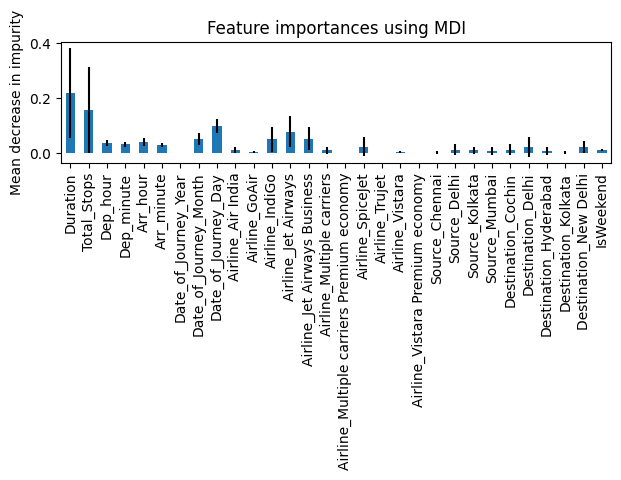

In [15]:
forest_importances = pd.Series(importances, index=list(data_train.columns))

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rand_search_estimator.best_estimator_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# 3. Evaluation

- [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
- [R-Squared](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

## 3.1 Before Tuning

In [16]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Evaluation before Tuning
untuned_estimator = RandomForestRegressor()
untuned_estimator.fit(data_train, target_train)
prediction_untuned = untuned_estimator.predict(data_test)

print("Before Tuning:")

# MAE
mae_untuned = mean_absolute_percentage_error(target_test, prediction_untuned)
# RMSE
rmse_untuned = mean_squared_error(target_test, prediction_untuned, squared=False)
# R-Squared
r2_untuned = r2_score(target_test, prediction_untuned)

print("MAE(%) = {}".format(mae_untuned*100))
print("RMSE = {}".format(rmse_untuned))
print("R-Squared = {}".format(r2_untuned))

Before Tuning:
MAE(%) = 13.505469526356068
RMSE = 1945.313451669342
R-Squared = 0.8177900163303716


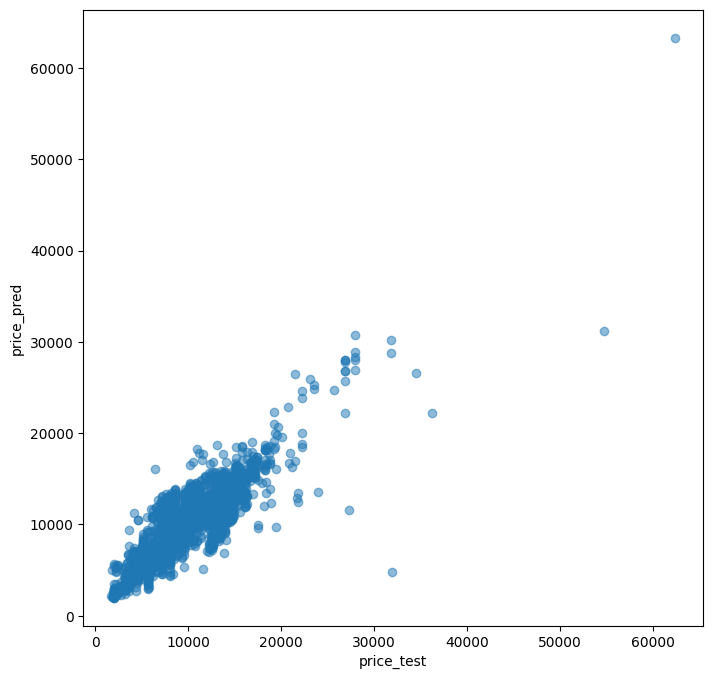

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(target_test, prediction_untuned, alpha=0.5)
plt.xlabel("price_test")
plt.ylabel("price_pred")
plt.show()

## 3.2 After Tuning

In [18]:
# Evaluation after Tuning

print("After Tuning:")

# MAE
mae = mean_absolute_percentage_error(target_test, prediction)
# RMSE
rmse = mean_squared_error(target_test, prediction, squared=False)
# R-Squared
r2 = r2_score(target_test, prediction)

print("MAE(%) = {}".format(mae*100))
print("RMSE = {}".format(rmse))
print("R-Squared = {}".format(r2))

After Tuning:
MAE(%) = 14.998342398752424
RMSE = 1977.1609216616873
R-Squared = 0.8117751214557573


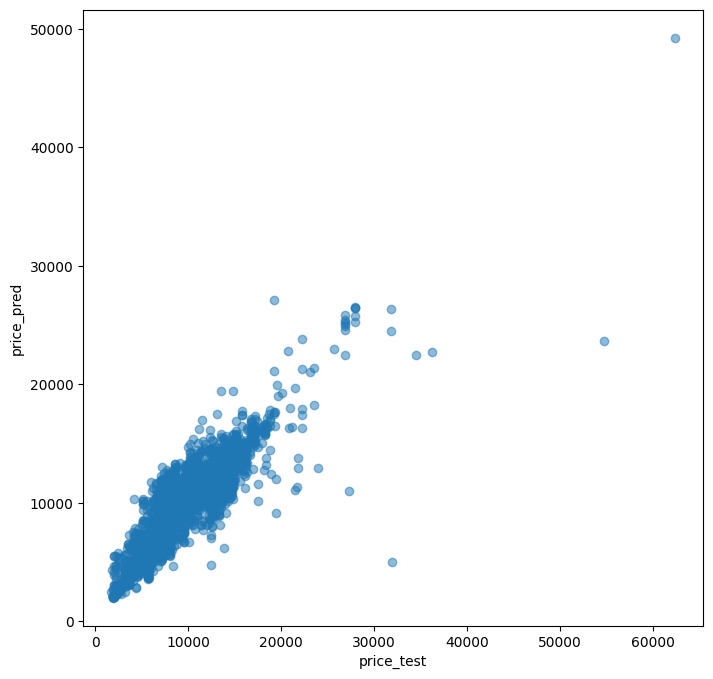

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(target_test, prediction, alpha=0.5)
plt.xlabel("price_test")
plt.ylabel("price_pred")
plt.show()